This notebook is going to look at the mistakes made by the chosen model. Specifically, it's going to look at the log loss for each class on the validation set and produce a Hinton diagram for all the classes to show the confusion matrix for this model. Then, it will find the class performing worst and plot example images from this class _after processing_.

Aiming for it to be written in such a way that the model file chosen can just be swapped in, so we can try it on different models.

Setup and prediction
=======

Doing the exact same thing as in the notebook on Holdout set testing, creating a set of predictions:

In [5]:
# copying imports from holdout notebook...
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.dense_dataset
import neukrill_net.utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hl
%load_ext holoviews.ipython
import sklearn.metrics

The holoviews.ipython extension is already loaded. To reload it, use:
  %reload_ext holoviews.ipython


In [9]:
cd ..

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work


In [11]:
settings = neukrill_net.utils.Settings("settings.json")
run_settings = neukrill_net.utils.load_run_settings(
    "run_settings/replicate_8aug.json", settings, force=True)

In [12]:
# loading the model
model = pylearn2.utils.serial.load(run_settings['pickle abspath'])

In [14]:
%pdb

Automatic pdb calling has been turned ON


In [27]:
# loading the data
yaml_string = neukrill_net.utils.format_yaml(run_settings, settings)
proxd = pylearn2.config.yaml_parse.load(yaml_string, instantiate=False).keywords['dataset']
proxd.keywords['force'] = True
proxd.keywords['training_set_mode'] = 'validation'
dataset = pylearn2.config.yaml_parse._instantiate(proxd)

True


In [31]:
batch_size=500
while len(dataset.X)%batch_size != 0:
    batch_size += 1
n_batches = int(len(dataset.X)/batch_size)
# set this batch size
model.set_batch_size(batch_size)
# compile Theano function
X = model.get_input_space().make_batch_theano()
Y = model.fprop(X)
f = theano.function([X],Y)

In [33]:
print(batch_size)

1513


In [100]:
%%time
y = np.zeros((len(dataset.X),len(settings.classes)))
i=0
iterator = dataset.iterator(batch_size=batch_size,num_batches=n_batches,
                            mode='even_sequential')
for batch in iterator:
    print(i)
    y[i*batch_size:(i+1)*batch_size] = f(batch[0])
    i+=1

0
1
CPU times: user 1.29 s, sys: 2.34 s, total: 3.63 s
Wall time: 11 s


In [101]:
labels = dataset.y

Log loss over image size
======

Looking at the effect of image size on log loss. Want to see how much it affects our ability to classify an image when it has been radically resized.

In [102]:
N = y.shape[0]

In [103]:
logloss = lambda x: -(1./N)*np.log(x[0][x[1]])

In [104]:
# iterate over all the images and make a list of log losses
ilabels = np.where(labels)[1]

In [115]:
losses = []
for r,l in zip(y,ilabels):
    losses.append(logloss([r,l]))
losses = np.array(losses)

Getting an array of original image sizes:

In [116]:
sizes = []
for i in dataset.X:
    sizes.append(np.sqrt(i.size))
sizes = np.array(sizes)

Then we can just make a scatter plot:

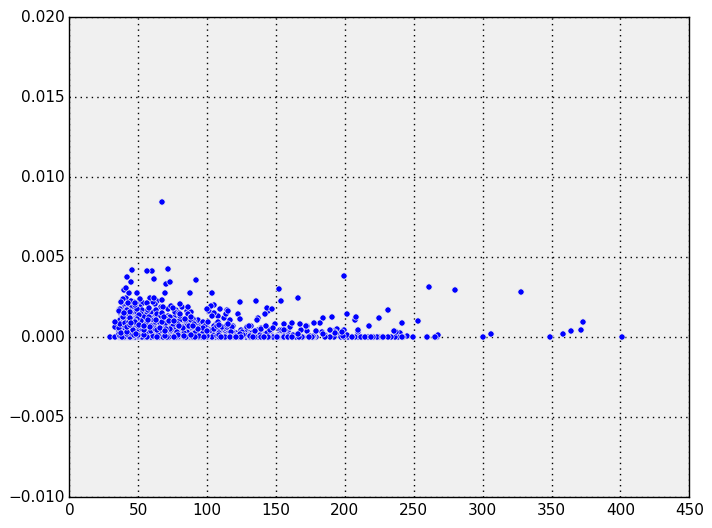

In [117]:
plt.scatter(sizes,losses)
plt.grid()

Doesn't appear to be a clear relationship between image size and log loss. We can look at the average log loss in a rolling average over the above plot and see where most of the log loss is:

In [146]:
np.hanning(50)*np.ones(50)

array([ 0.        ,  0.00410499,  0.01635257,  0.03654162,  0.06434065,
        0.09929319,  0.14082532,  0.1882551 ,  0.24080372,  0.29760833,
        0.35773621,  0.42020005,  0.48397421,  0.54801151,  0.61126047,
        0.67268253,  0.73126915,  0.78605833,  0.83615045,  0.88072298,
        0.91904405,  0.95048443,  0.97452787,  0.99077958,  0.9989727 ,
        0.9989727 ,  0.99077958,  0.97452787,  0.95048443,  0.91904405,
        0.88072298,  0.83615045,  0.78605833,  0.73126915,  0.67268253,
        0.61126047,  0.54801151,  0.48397421,  0.42020005,  0.35773621,
        0.29760833,  0.24080372,  0.1882551 ,  0.14082532,  0.09929319,
        0.06434065,  0.03654162,  0.01635257,  0.00410499,  0.        ])

In [175]:
ravg = np.zeros(450)
for i in range(450):
    s = losses[(sizes > i-50) * (sizes < i+50)]
    # apply window function
    s = s*np.hanning(s.size)
    if s.size != 0:
        ravg[i] = np.mean(s)
    else:
        ravg[i] = 0

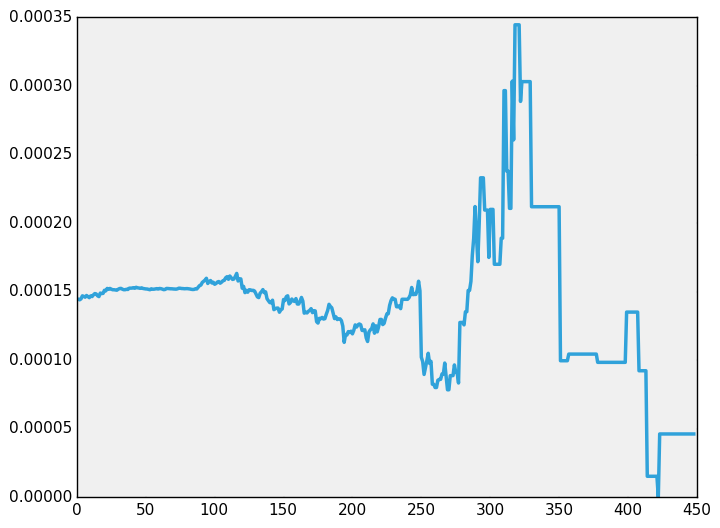

In [177]:
plt.plot(range(450),ravg)

So it looks like we are losing more log loss per image at higher image sizes. _However_, most of log loss is going to be at the lower image sizes because there are more images there. If we do a rolling sum we'll see this: 

In [178]:
rsum = np.zeros(450)
for i in range(450):
    s = losses[(sizes > i-30) * (sizes < i+30)]
    # apply window function
    s = s*np.hanning(s.size)
    if s.size != 0:
        rsum[i] = np.sum(s)
    else:
        rsum[i] = 0

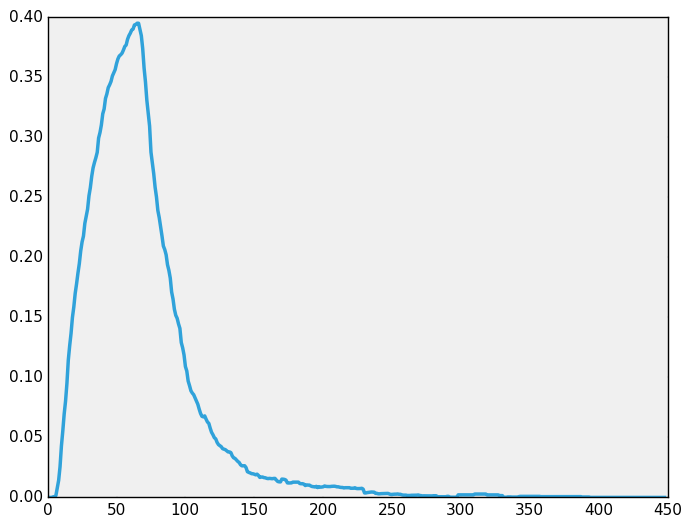

In [180]:
plt.plot(range(450),rsum)

So, cumulatively we should probably worry more about the lower image sizes anyway.

Does the parallel model do better?
============

We've trained a model with parallel streams which should in theory do better at this kind of task; as it has more information about the size of different classes.

In [181]:
settings = neukrill_net.utils.Settings("settings.json")
run_settings = neukrill_net.utils.load_run_settings(
    "run_settings/parallel_conv.json", settings, force=True)

In [182]:
model = pylearn2.utils.serial.load(run_settings['pickle abspath'])

In [183]:
# loading the data
yaml_string = neukrill_net.utils.format_yaml(run_settings, settings)
proxd = pylearn2.config.yaml_parse.load(yaml_string, instantiate=False).keywords['dataset']
proxd.keywords['force'] = True
proxd.keywords['training_set_mode'] = 'validation'
dataset = pylearn2.config.yaml_parse._instantiate(proxd)

In [185]:
batch_size=500
while len(dataset.X)%batch_size != 0:
    batch_size += 1
n_batches = int(len(dataset.X)/batch_size)
# set this batch size
model.set_batch_size(batch_size)
# compile Theano function
X = model.get_input_space().make_batch_theano()
Y = model.fprop(X)
f = theano.function(X,Y)

In [186]:
%%time
y = np.zeros((len(dataset.X),len(settings.classes)))
i=0
iterator = dataset.iterator(batch_size=batch_size,num_batches=n_batches,
                            mode='even_sequential')
for batch in iterator:
    print(i)
    y[i*batch_size:(i+1)*batch_size] = f(batch[0],batch[1])
    i+=1

0
1
CPU times: user 2.62 s, sys: 4.89 s, total: 7.51 s
Wall time: 16.7 s


In [187]:
losses = []
for r,l in zip(y,ilabels):
    losses.append(logloss([r,l]))
losses = np.array(losses)

The scatter plot looks _slightly_ better at the higher values:

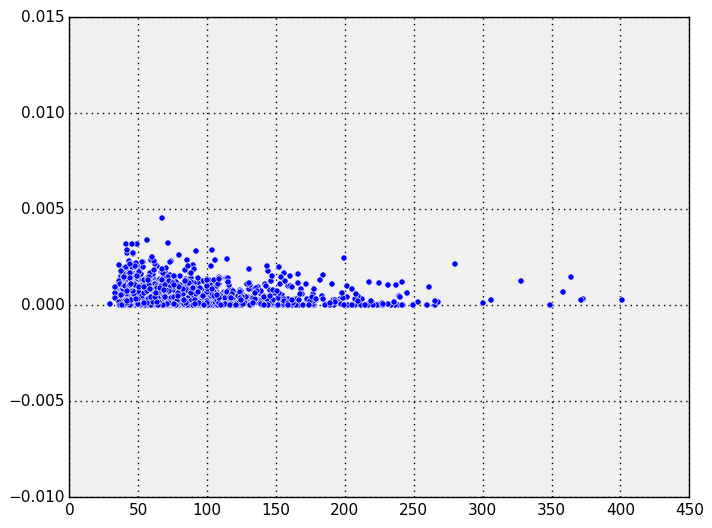

In [188]:
plt.scatter(sizes,losses)
plt.grid()

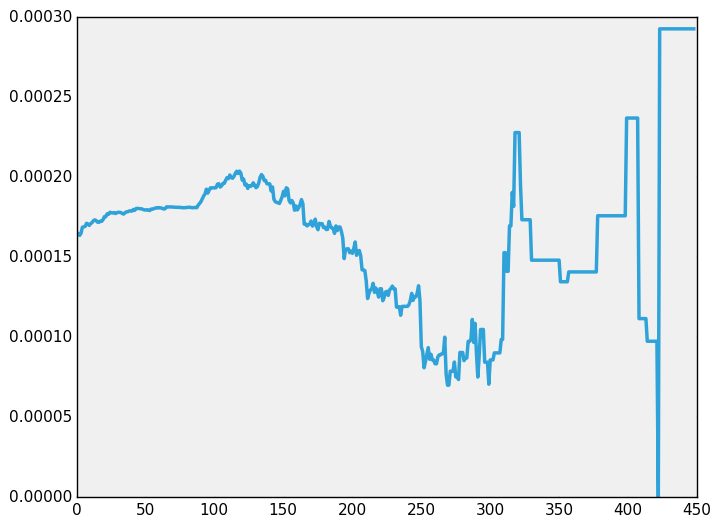

In [189]:
ravg = np.zeros(450)
for i in range(450):
    s = losses[(sizes > i-50) * (sizes < i+50)]
    # apply window function
    s = s*np.hanning(s.size)
    if s.size != 0:
        ravg[i] = np.mean(s)
    else:
        ravg[i] = 0
plt.plot(range(450),ravg)

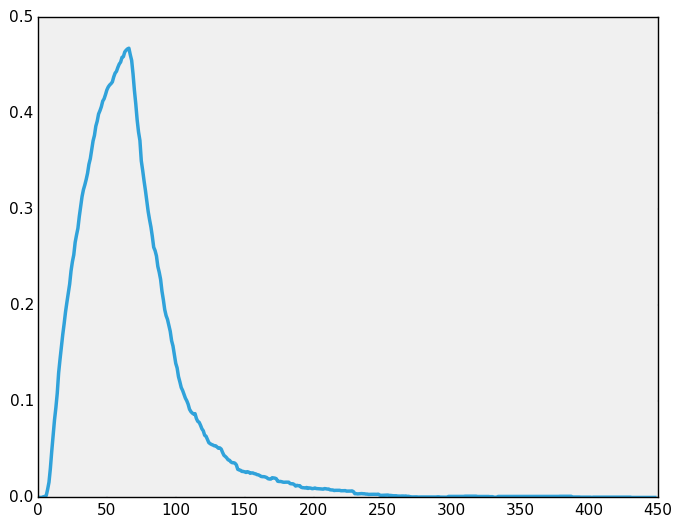

In [190]:
rsum = np.zeros(450)
for i in range(450):
    s = losses[(sizes > i-30) * (sizes < i+30)]
    # apply window function
    s = s*np.hanning(s.size)
    if s.size != 0:
        rsum[i] = np.sum(s)
    else:
        rsum[i] = 0
plt.plot(range(450),rsum)

It _might_ do a little better, but it's difficult to see any kind of difference that would be significant.